In [3]:
import optuna
from optuna.integration.tensorboard import TensorBoardCallback
from optuna.trial import TrialState

from xgboost import XGBRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer
from sklearn.pipeline import FeatureUnion, make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import (
    LabelEncoder,
    StandardScaler,
    OneHotEncoder,
    FunctionTransformer,
)
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn import config_context

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter

import pandas as pd
import numpy as np
from plotnine import *
from mizani.formatters import comma_format, percent_format, currency_format
from datetime import datetime, timedelta, date
from tqdm.notebook import tqdm
from skimpy import clean_columns
from IPython.display import clear_output, display
import holidays
from pickle import dump, load
import warnings  

pd.set_option("display.max.columns", 50)

%load_ext blackcellmagic

### Reading in the Preprocessed Data and Making Base Splits

In [2]:
df = pd.read_csv("Preprocessed Data/df_base_trainval_preprocessed.csv", parse_dates=["Zeitstempel"])

In [3]:
X, y = df.drop(["Zeitstempel", "MWh"], axis=1), df["MWh"]

In [4]:
preprocessor = load(open('Models/sklearn_base_pipeline_unfitted.pickle', 'rb'))

In [5]:
tscv = TimeSeriesSplit(n_splits=5)

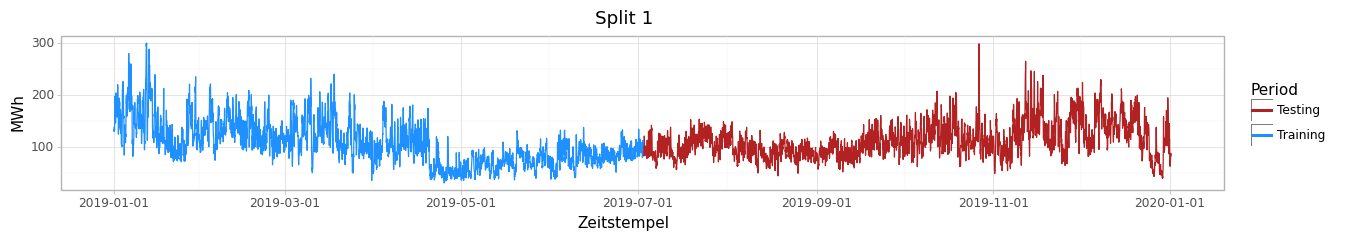

<ggplot: (154420992115)>

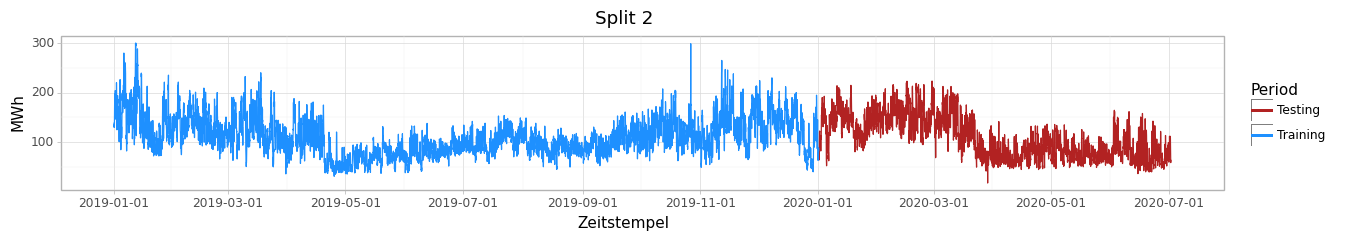

<ggplot: (154421025297)>

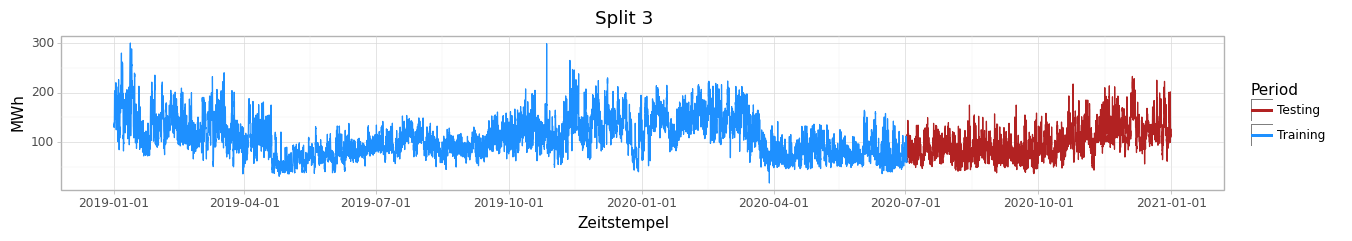

<ggplot: (154420977193)>

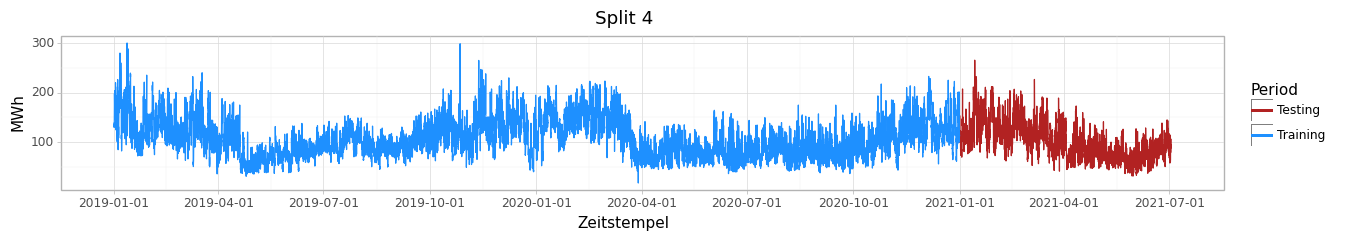

<ggplot: (154423860306)>

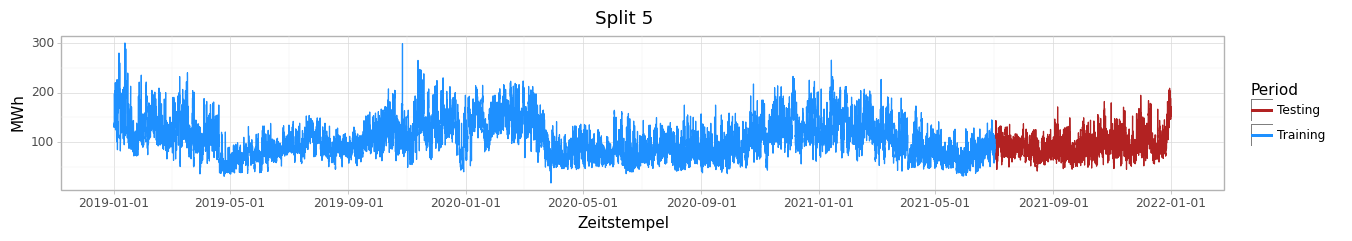

<ggplot: (154423850468)>

In [6]:
# Iterate through the splits
for split_idx, (train_index, test_index) in enumerate(tscv.split(X)):
    train_dates = df["Zeitstempel"].iloc[train_index]
    test_dates = df["Zeitstempel"].iloc[test_index]

    y_train, y_test = pd.DataFrame(
        {
            "Zeitstempel": train_dates.reset_index(drop=True),
            "MWh": y.iloc[train_index].reset_index(drop=True),
            "Period": "Training",
        }
    ), pd.DataFrame(
        {
            "Zeitstempel": test_dates.reset_index(drop=True),
            "MWh": y.iloc[test_index].reset_index(drop=True),
            "Period": "Testing",
        }
    )

    with warnings.catch_warnings():  # sanest pandas user
        warnings.simplefilter("ignore")

        p = (
            ggplot(
                data=pd.concat([y_train, y_test], axis=0),
                mapping=aes(x="Zeitstempel", y="MWh", colour="Period"),
            )
            + labs(title=f"Split {split_idx + 1}")
            + geom_line()
            + scale_colour_manual(values=["firebrick", "dodgerblue"])
            + theme_light()
            + theme(figure_size=[15, 2])
        )
        display(p)

In [9]:
fitted_preprocessor = preprocessor.fit(X)

C:\Users\mathi\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
C:\Users\mathi\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
C:\Users\mathi\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
C:\Users\mathi\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
C:\Users\mathi\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: F

In [11]:
with open("Models/preprocessor_trainval.pickle", 'wb') as file:
    dump(fitted_preprocessor, file)

### Training and Tuning with XGBoost and Optuna

Let's first take a look at how the training features look after being transformed with the sklearn pipeline in each split:

In [7]:
with warnings.catch_warnings():  # sanest pandas user
    warnings.simplefilter("ignore")

    for train_index, test_index in tscv.split(X):
        X_train, X_test = X.iloc[train_index].reset_index(drop=True), X.iloc[test_index].reset_index(drop=True)
        y_train, y_test = y.iloc[train_index].reset_index(drop=True), y.iloc[test_index].reset_index(drop=True)
        
        # Fit preprocessor on each training split
        fitted_preprocessor = preprocessor.fit(X_train)
        
        X_train = pd.DataFrame(
            fitted_preprocessor.transform(X_train),
            columns=fitted_preprocessor.get_feature_names_out(),
        )

        X_test = pd.DataFrame(
            fitted_preprocessor.transform(X_test),
            columns=fitted_preprocessor.get_feature_names_out(),
        )

        break

In [8]:
X_train

,numeric__temperature_fore_ch,numeric__temperature_fore_fr,numeric__temperature_fore_de,numeric__temperature_fore_it,numeric__solar_fore_de_mw,numeric__solar_fore_it_mw,numeric__wind_fore_de_mw,numeric__wind_fore_it_mw,numeric__CH_AT,numeric__CH_DE,numeric__CH_FR,numeric__CH_IT,numeric__AT_CH,numeric__DE_CH,numeric__FR_CH,numeric__IT_CH,numeric__year,numeric__hour_counter,numeric__hour_sin,numeric__hour_cos,numeric__week_hour_sin,numeric__week_hour_cos,numeric__month_sin,numeric__month_cos,numeric__quarter_sin,...,numeric__target_lag_155,numeric__target_lag_156,numeric__target_lag_157,numeric__target_lag_158,numeric__target_lag_159,numeric__target_lag_160,numeric__target_lag_161,numeric__target_lag_162,numeric__target_lag_163,numeric__target_lag_164,numeric__target_lag_165,numeric__target_lag_166,numeric__target_lag_167,categorical__weekend_0,categorical__weekend_1,categorical__work_hour_0,categorical__work_hour_1,categorical__holiday_name_Auffahrt,categorical__holiday_name_Karfreitag,categorical__holiday_name_Neujahrestag,categorical__holiday_name_Ostermontag,categorical__holiday_name_Ostern,categorical__holiday_name_Pfingsten,categorical__holiday_name_Pfingstmontag,categorical__holiday_name_none
0,-0.685388,-0.891008,-0.331776,-1.174644,-0.703026,-0.763611,0.746805,1.273010,0.444964,0.445439,0.088378,0.471834,0.875518,-1.235905,0.739629,0.976563,0.0,-1.731656,0.365682,1.367307,1.129421,0.839651,-0.307883,1.517845,0.996782,...,0.000000,-4.230669e-16,0.000000,4.126091e-16,4.137891e-16,0.0000,0.000000,5.162912e-16,-4.963203e-16,-4.448504e-16,3.982893e-16,0.000000,-3.198850e-16,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,-0.685388,-0.891008,-0.331776,-1.174644,-0.703026,-0.763611,0.921293,1.469920,0.444964,0.445439,0.088378,0.471834,0.875518,-1.235905,0.739629,0.976563,0.0,-1.730867,0.706672,1.225988,1.159970,0.796437,-0.307883,1.517845,0.996782,...,0.000000,-4.230669e-16,0.000000,4.126091e-16,4.137891e-16,0.0000,0.000000,5.162912e-16,-4.963203e-16,-4.448504e-16,3.982893e-16,0.000000,-3.198850e-16,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,-0.685388,-0.891008,-0.331776,-1.174644,-0.703026,-0.763611,1.117258,1.390836,0.444964,0.445439,0.088378,0.471834,0.875518,-1.235905,0.739629,0.976563,0.0,-1.730078,0.999486,1.001183,1.188887,0.752106,-0.307883,1.517845,0.996782,...,0.000000,-4.230669e-16,0.000000,4.126091e-16,4.137891e-16,0.0000,0.000000,5.162912e-16,-4.963203e-16,-4.448504e-16,3.982893e-16,0.000000,-3.198850e-16,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,-0.685388,-0.891008,-0.331776,-1.174644,-0.703026,-0.763611,1.333185,1.286862,0.444964,0.445439,0.088378,0.471834,0.875518,-1.235905,0.739629,0.976563,0.0,-1.729288,1.224170,0.708210,1.216133,0.706721,-0.307883,1.517845,0.996782,...,0.000000,-4.230669e-16,0.000000,4.126091e-16,4.137891e-16,0.0000,0.000000,5.162912e-16,-4.963203e-16,-4.448504e-16,3.982893e-16,0.000000,-3.198850e-16,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,-0.685388,-0.891008,-0.331776,-1.174644,-0.703026,-0.763611,1.313565,1.225528,0.444964,0.445439,0.088378,0.471834,0.875518,-1.235905,0.739629,0.976563,0.0,-1.728499,1.365413,0.367037,1.241669,0.660345,-0.307883,1.517845,0.996782,...,0.000000,-4.230669e-16,0.000000,4.126091e-16,4.137891e-16,0.0000,0.000000,5.162912e-16,-4.963203e-16,-4.448504e-16,3.982893e-16,0.000000,-3.198850e-16,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4384,2.394984,2.182310,1.498277,2.482488,1.566161,1.421591,0.305445,-0.903369,-0.059428,-2.019028,0.088378,-0.091431,-0.348954,-1.235905,-1.788894,-1.807661,0.0,1.728499,-1.365902,-0.365212,1.404266,0.051268,-3.143728,-0.999328,-2.850954,...,0.245575,-1.369598e-01,-0.500017,-1.858879e-01,-2.796760e-01,-0.5301,-0.318035,5.488929e-01,6.742775e-01,4.043594e-01,-1.062550e-01,-0.121488,-3.935392e-01,1.0,0.0

Looks good, let's get crackin:

In [9]:
def objective(trial):
          
    params = {
        'objective': 'reg:squarederror',
        'eval_metric': 'mae',
        'learning_rate': trial.suggest_float('learning_rate', 0.00001, 1),
        'n_estimators': trial.suggest_int('n_estimators', 50, 750),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'subsample': trial.suggest_float('subsample', 0.05, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.05, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0),
    }

    mae_cv_list = []

    with warnings.catch_warnings(): # sanest pandas user
        warnings.simplefilter("ignore")

        # Iterate through the splits
        for train_index, test_index in tscv.split(X):
            X_train, X_test = X.iloc[train_index].reset_index(drop=True), X.iloc[test_index].reset_index(drop=True)
            y_train, y_test = y.iloc[train_index].reset_index(drop=True), y.iloc[test_index].reset_index(drop=True)
            
            # Fit preprocessor on each training split
            fitted_preprocessor = preprocessor.fit(X_train)
            
            X_train = pd.DataFrame(
                fitted_preprocessor.transform(X_train),
                columns=fitted_preprocessor.get_feature_names_out(),
            )

            X_test = pd.DataFrame(
                fitted_preprocessor.transform(X_test),
                columns=fitted_preprocessor.get_feature_names_out(),
            )

            # Example using a hypothetical model (replace with your actual model):
            model = XGBRegressor(**params)
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)

            # Calculate evaluation metrics (e.g., MSE, MAE, etc.) for each fold
            # Example using mean squared error (MSE):
            mae_cv_list.append(mean_absolute_error(y_test, y_pred))
            
    return np.mean(mae_cv_list)

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10000, timeout=3600*8)

[I 2023-09-15 23:15:52,489] A new study created in memory with name: no-name-07df7a8f-9334-4980-adf2-c22acd8706f6
[I 2023-09-15 23:17:14,502] Trial 0 finished with value: 22.763433890709802 and parameters: {'learning_rate': 0.35794425022941456, 'n_estimators': 408, 'max_depth': 12, 'subsample': 0.5070839428840582, 'colsample_bytree': 0.3041821463391221, 'reg_alpha': 0.4216248211553888, 'reg_lambda': 0.13231667414450865}. Best is trial 0 with value: 22.763433890709802.
[I 2023-09-15 23:18:25,032] Trial 1 finished with value: 18.545127113381152 and parameters: {'learning_rate': 0.04810005754278676, 'n_estimators': 526, 'max_depth': 4, 'subsample': 0.6324237580040837, 'colsample_bytree': 0.9499778758006681, 'reg_alpha': 0.030949050158381675, 'reg_lambda': 0.2804596739154286}. Best is trial 1 with value: 18.545127113381152.
[I 2023-09-15 23:19:20,220] Trial 2 finished with value: 19.460001635840353 and parameters: {'learning_rate': 0.08765327897344255, 'n_estimators': 249, 'max_depth': 12,

In [10]:
pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

# Display the study statistics
print("\nStudy statistics: ")
print(f"  Number of finished trials: {len(study.trials)}")
print(f"  Number of pruned trials: {len(pruned_trials)}")
print(f"  Number of complete trials: {len(complete_trials)}")


Study statistics: 
  Number of finished trials: 877
  Number of pruned trials: 0
  Number of complete trials: 877


In [22]:
study.trials_dataframe().to_csv("Models/xgboost_tuning_optuna.csv", index=False)

In [11]:
study.best_value

17.838948195746013

In [12]:
study.best_params

{'learning_rate': 0.03665415765619678,
 'n_estimators': 441,
 'max_depth': 3,
 'subsample': 0.6401022681410813,
 'colsample_bytree': 0.6591106781161146,
 'reg_alpha': 0.5532465158240171,
 'reg_lambda': 0.6530689127970454}

In [13]:
with open("Models/XGBoost_hyperparams.pickle", 'wb') as file:
    dump(study.best_params, file)

### Training Best Model on Training + Validation Data

The best hyperparameters for this model are already known, so let's train the best model on the training AND validation data.

Here, I need to refit the sklearn pipeline to the entire dataset in order to make the training consistent.

In [7]:
preprocessor = load(open('Models/sklearn_base_pipeline_unfitted.pickle', 'rb'))

In [8]:
# Read in best hyperparameter combination from tuning
with open("Models/XGBoost_hyperparams.pickle", 'rb') as file:
    best_config = load(file)

In [9]:
df = pd.read_csv("Preprocessed Data/df_base_trainval_preprocessed.csv")

X_train_final = (
    df
    .drop(["Zeitstempel", "MWh"], axis=1)
    .reset_index(drop=True)
)
y_train_final = df["MWh"].reset_index(
    drop=True
)

In [10]:
fitted_preprocessor = preprocessor.fit(X_train_final)

C:\Users\mathi\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
C:\Users\mathi\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
C:\Users\mathi\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
C:\Users\mathi\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
C:\Users\mathi\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: F

In [11]:
X_train_final = pd.DataFrame(
    fitted_preprocessor.transform(X_train_final),
    columns=fitted_preprocessor.get_feature_names_out(),
)

C:\Users\mathi\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
C:\Users\mathi\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
C:\Users\mathi\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
C:\Users\mathi\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
C:\Users\mathi\AppData\Roaming\Python\Python310\site-packages\sklearn\utils\validation.py:605: F

In [12]:
model = XGBRegressor(**best_config)
model.fit(X_train_final, y_train_final)

C:\Users\mathi\AppData\Roaming\Python\Python310\site-packages\xgboost\data.py:297: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
C:\Users\mathi\AppData\Roaming\Python\Python310\site-packages\xgboost\data.py:299: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
C:\Users\mathi\AppData\Roaming\Python\Python310\site-packages\xgboost\data.py:364: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1,
             colsample_bytree=0.6591106781161146, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.03665415765619678,
             max_bin=256, max_cat_to_onehot=4, max_delta_step=0, max_depth=3,
             max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=441, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0.5532465158240171, reg_lambda=0.6530689127970454, ...)

In [20]:
with open("Models/xgboost_trainval.pickle", 'wb') as file:
    dump(model, file)